---
title: Linear Convection with Jax
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

In this tutorial, we will go over the simple 1D Linear Convection scheme. We will break down how we solve the PDE into abstractions. For each of these abstractions so that we can see how we can think in the Jax context. At the end of the tutorial, we will have an implementation within the JAX context.


Summary of Steps:

* 1D Linear Convection PDE
* Forward-Time-Backwards-Space (FTBS)
* Simple Time Stepper - Euler
* Break Problem into chunks
* Jax-ified Version
    * Functional
    * Explicit Types

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import kernex as kex
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree
import wandb

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Problem - PDE

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [3]:
# PDE params
c = 1.0
sigma = 1.0

# spatial discretization
xmin = 0.0
xmax = 2.0
nx = 50
dx = xmax / (nx - 1)
x_grid = np.linspace(xmin, xmax, nx)

# temporal discretization
t0 = 0.0
tmax = 0.5

### CFL Condition

This is necessary for convergence.

$$
\sigma = \frac{c\Delta t}{\Delta x} \leq 1
$$ (cfl_advection)

So rearranging, we can find the correct time step given the CFL condition.

$$
\Delta t = \frac{\sigma\Delta x}{c} \leq 1
$$ (cfl_advection_dt)

In [4]:
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c


sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)

time_steps = np.arange(t0, tmax, dt)

print(f"Δt = {dt:2f}")

Δt = 0.008163


In [5]:
solns = dict()


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


In [6]:
# initialize field to be zero
u_init = np.ones((nx,))
u_init[int(.5 / dx):int(1 / dx + 1)] = 2.0

u = u_init.copy()


for t in tqdm(time_steps):
    
    # copy to avoid overwriting
    
    # calculate the terms
    u[1:] = u[1:] - c * (dt / dx) * (u[1:] - u[:-1])
    
    # boundaries
    u[0] = 1.0
    u[-1] = 1.0
    


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()
solns["numpy"] = u

  0%|          | 0/62 [00:00<?, ?it/s]

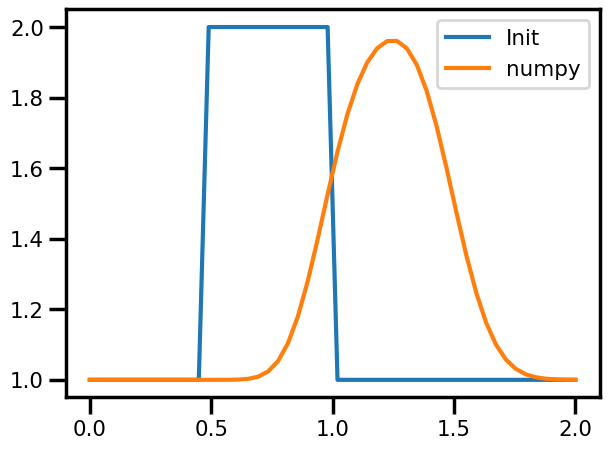

In [7]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init, label="Init")
ax.plot(x_grid, solns["numpy"], label="numpy")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# initialize field to be zero
u_init = jnp.ones((nx,), dtype=jnp.float32)
u_init = u_init.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
u = u_init.copy()

for t in tqdm(time_steps):
    
    # # loops (BUG!)
    # for i in range(1, u.shape[0]-1):
    #     u = u.at[i].set(u[i] - c * (dt/dx) * (u[i] - u[i-1]))
    
    # numpy-like
    u = u.at[1:].set(u[1:] - c * (dt / dx) * (u[1:] - u[:-1]))
        
    u = u.at[0].set(1.0)
    u = u.at[-1].set(1.0)
    
    


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()
solns["jax"] = u

2023-02-25 12:54:45.528029: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


  0%|          | 0/62 [00:00<?, ?it/s]

2023-02-25 12:54:45.615187: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-02-25 12:54:45.626844: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


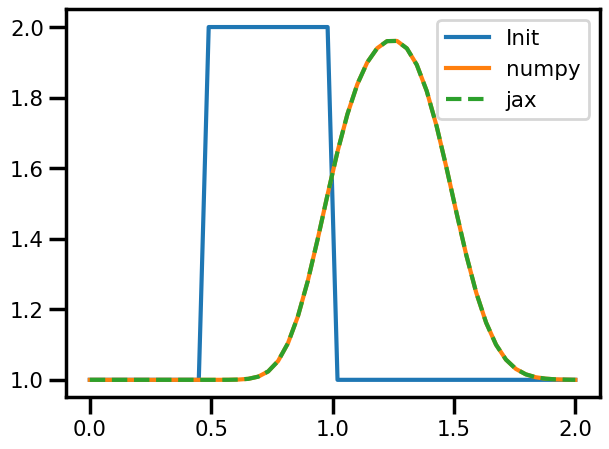

In [9]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init, label="Init")
ax.plot(x_grid, solns["numpy"], label="numpy", linestyle="-")
ax.plot(x_grid, solns["jax"], label="jax", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

## Jax-ify

Now, we should jax-ify all of the things. The biggest thing is that everything should be *somewhat* funtional.

---
**Components**

There are definitely some components here that I can identify from the above code.

* Initialization Function
* RHS Function (including FD Operator)
* Boundary Conditions
* Step Function

## Discretization

### Spatial

In [10]:
# spatial discretization
xmin = 0.0
xmax = 2.0
nx = 50
dx = xmax / (nx - 1)

# spatial grid
x_grid = np.linspace(xmin, xmax, nx)

# check dx
assert x_grid[1] - x_grid[0] == dx

### Temporal

In [11]:
# temporal discretization
t0 = 0.0
tmax = 0.5

# CFL Conditions
sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)


# Temporal Grid
time_steps = np.arange(t0, tmax, dt)

### Parameters

In [12]:
# PDE params
c = 1.0

### Initialization Function


$$
\mathcal{IC}[u](x,0) = 
\begin{cases}
2 & \text{where } 0.5 \leq x \leq 1,\\
1 & \text{everywhere else in } (0,2) \\
\end{cases}
$$ (ic)

In [13]:
# initialize field to be zero


def init_u_fn(grid: Float[Array, "D"]) -> Float[Array, "D"]:
    """Initial condition from grid"""
    u = jnp.ones_like(grid, dtype=jnp.float64)
    
    u = u.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
    
    return u

### Boundary Conditions

$$
\mathcal{BC}[u](x, t) = 1.0, \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)

In [14]:
def bc_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    
    u = u.at[0].set(1.0)
    
    u = u.at[-1].set(1.0)
    
    # TODO: can use where based on points
    return u


### RHS

So for this, the right-hand side is the following

$$
\mathcal{RHS}[u]:=\mathcal{F}[u;\theta](x) = - c \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
$$ (rhs)

We also can see that we can abstract the backwards finite difference operator as well.

$$
\begin{aligned}
\mathcal{F}[u] &= - c \cdot \mathcal{N}[u](x) \hspace{10mm} x\in\Omega \\
\mathcal{N}[u]:=\mathcal{N}_{BD}[u] &= \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right) \\
\end{aligned}
$$ (rhs_complete)

#### Finite Difference Operator

$$
\mathcal{N}_{BD}[u] = \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
$$ (bd)

In [15]:
# 1st order backwards finite difference operator
@kex.kmap(kernel_size=(2,), padding="valid", relative=True)
def fd_back(u: Float[Array, "2"], dx: PyTree[float]) -> Float[Array, ""]:
    return (u[1] - u[0]) / dx

#### Final RHS

In [16]:
# RHS function
def rhs_fn(u: Float[Array, "D"], dx: PyTree[float], c: PyTree[float]) -> Float[Array, "D"]:
    """RHS for 1D Advection. 
    Uses a Backwards FD scheme
    """
    # removes artefact from stencil operation
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    
    # FD
    u = fd_back(u, dx)
    
    # constant
    u = - c * u
    
    return u

### Step Function

Now, we want to put all of this together. So we're going to create a step function that will allow us to take a state, $u$, apply the FD operator, apply the boundary conditions, return the RHS, and step forward one iteration in time. 

The most general form of this step function is

$$
u_{t+1} = u_t + \boldsymbol{g}(u_t, t)
$$ (step_fn_general)
which basically says that "the next state is the current state plus something". There are many such time-steppers in the literature ranging from Taylor-based schemes (e.g. Euler) to quadrature schemes (e.g. Runga-Kutta). All have pros and cons and we can spend a long time trying to look at all of them. For this example, we will use a simple Euler time stepper.

$$
u_{t+1} = u_t + \Delta t \boldsymbol{f}(u_t)
$$ (step)

It's not the best, but it is fine for a simple problem. 


So we can write a general step of operations for the Stepper as well.

$$

\mathcal{RHS}[u]:= 
\begin{cases}
\mathcal{F}[u] & x\in\Omega\\
\mathcal{B}[u] & x\in\partial\Omega \\
\end{cases}
$$ (stepper)

In [17]:

def step_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    
    # apply bcs for current state
    u = bc_fn(u)
    
    # calculate RHS
    rhs = rhs_fn(u, dx, c)
    
    # time step
    u = u + dt * rhs
    
    return u

step_fn = jax.jit(step_fn)


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()

In [18]:
# initialize u from grid
u = init_u_fn(x_grid)

# loop through time steps
for t in tqdm(time_steps):
    
    # step
    u = step_fn(u)
    
solns["jaxify"] = u

2023-02-25 12:54:46.387247: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


  0%|          | 0/62 [00:00<?, ?it/s]

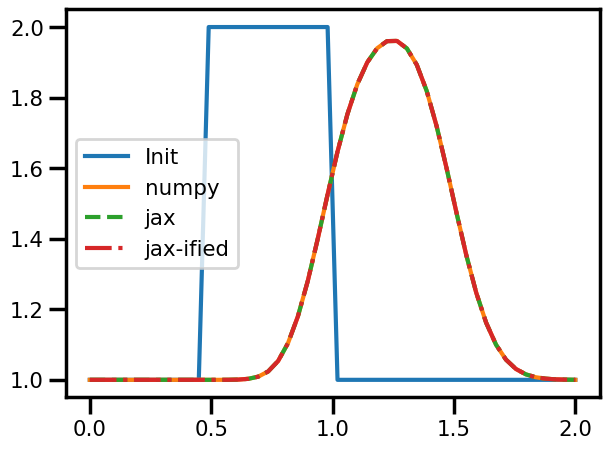

In [19]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init, label="Init")
ax.plot(x_grid, solns["numpy"], label="numpy", linestyle="-")
ax.plot(x_grid, solns["jax"], label="jax", linestyle="--")
ax.plot(x_grid, solns["jaxify"], label="jax-ified", linestyle="-.")
plt.legend()
plt.tight_layout()
plt.show()